In [1]:
import os
import collections

%matplotlib inline
import matplotlib as mpl    
import matplotlib.pyplot as plt    
import matplotlib.gridspec
mpl.rcParams['figure.figsize'] = (10.0, 5.0)

import numpy as np
import astropy.io.fits as pyfits

import grizli

### Dev
import grizlidev as grizli
import grizlidev
reload(grizlidev.utils_c); reload(grizlidev.model); 
reload(grizlidev.grismconf); reload(grizlidev.utils); reload(grizlidev); reload(grizli)

<module 'grizlidev' from '/Users/brammer/.local/lib/python2.7/site-packages/grizlidev/__init__.pyc'>

In [2]:
# # Fetch sample data
# os.chdir('/tmp/')
# os.system('wget http://www.stsci.edu/~brammer/grism/grizli_demo_data.tar.gz')
# os.system('tar xzvf grizli_demo_data.tar.gz')

### Initialize the GrismFLT object
The `GrismFLT` object takes as input grism FLT files and optionally direct image FLT files or reference images and segmentation maps.  For this example, provide just a pair of grism (G141) and direct (F140W) FLT files (taken from a visit on the UDF field from 3D-HST).  

Note that the two FITS files provided here have been astrometrically aligned and background subtracted externally to `grizli` in its current implementation.  These are clearly critical and non-trivial steps of the data preparation process and this functionality will be incorporated into the full `grizli` release shortly.  

In [3]:
flt = grizli.model.GrismFLT(grism_file='ibhj34h8q_flt.fits', direct_file='ibhj34h6q_flt.fits',
                            pad=200, ref_file=None, ref_ext=0, seg_file=None, shrink_segimage=False)

### Catalog / segmentation image
Make a catalog/segmentation image from the direct FLT and make a full grism model for the first four grism orders for those detected objects.  Uses `photutils` to generate the segmentation image/catalog.

In [4]:
flt.photutils_detection(detect_thresh=2, grow_seg=5, gauss_fwhm=2.,  
                        verbose=True, save_detection=False, data_ext='SCI')

ibhj34h6q_flt: photutils.detect_sources (detect_thresh=2.0, grow_seg=5, gauss_fwhm=2.0, ZP=26.5)
ibhj34h6q_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
ibhj34h6q_flt: photutils.source_properties - 179 objects


True

Number of objects in `photutils` catalog: 179


(200, 1214)

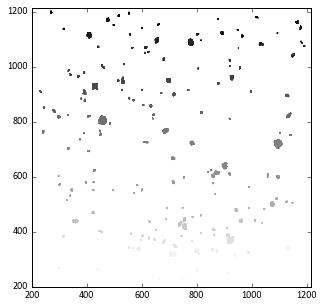

In [5]:
print 'Number of objects in `photutils` catalog: %d' %(len(flt.catalog))
plt.imshow(flt.seg, cmap='gray_r', origin='lower')
plt.xlim(flt.pad, flt.direct.sh[1]-flt.pad)
plt.ylim(flt.pad, flt.direct.sh[0]-flt.pad)

In [6]:
# Find the object near detector (x,y) = (712, 52) 
xi, yi = 712+flt.pad, 52+flt.pad # nice line

#xi, yi = 779, 722 # bright red
#xi, yi = 695, 949 # big extended H-alpha
#xi, yi = 586, 337 # fainter line, [OIII]?
#xi, yi = 421, 470 # fainter line
#xi, yi = 858, 408 # bright [OIII]
#xi, yi = 940, 478 # fainter line

dr = np.sqrt((flt.catalog['x_flt']-xi)**2+(flt.catalog['y_flt']-yi)**2)
ix = np.argmin(dr)
id = flt.catalog['id'][ix]
mag = flt.catalog['mag'][ix]
x0 = flt.catalog['x_flt'][ix]+1
y0 = flt.catalog['y_flt'][ix]+1
print '   id=%d, (x,y)=(%.1f, %.1f), mag=%.2f' %(id, x0, y0, mag)

## Get properties of the object from the segmentation region alone
## regardless of whether you have the detection catalog
out = grizli.utils_c.disperse.compute_segmentation_limits(flt.seg, id,
                                                          flt.direct.data['SCI'],
                                                          flt.direct.sh)
ymin, ymax, yseg, xmin, xmax, xseg, area, segm_flux = out
print 'Segment: (x,y)=(%.1f, %.1f) # zero index' %(xseg, yseg)

   id=6, (x,y)=(913.0, 252.2), mag=22.54
Segment: (x,y)=(912.0, 251.2) # zero index


### Basic trace parameters
Get basic trace parameters, `conf` is a grizli.grism.aXeConf object, here for G141 & F140W.

`dx` is simply the x pixel offset from the center of the direct image.  Here it is integers, but it can be anything.


In [7]:
# x pixels from the center of the direct image
dx = np.arange(220)
# ytrace and wavelength at x=dx
dy, lam = flt.conf.get_beam_trace(x=x0-flt.pad, y=y0-flt.pad, dx=dx, beam='A')
# it's fast
%timeit dy, lam = flt.conf.get_beam_trace(x=x0-flt.pad, y=y0-flt.pad, dx=dx, beam='A')

1000 loops, best of 3: 262 µs per loop


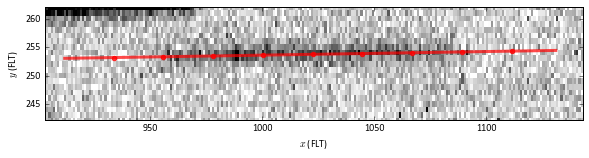

In [8]:
### Make a figure showing the trace in the FLT frame
fig = plt.figure(figsize=[8,2])

ax = fig.add_subplot(111)
ax.imshow(flt.grism.data['SCI'], cmap='gray_r', vmin=-0.05, vmax=0.2, 
          interpolation='Nearest', aspect='auto')
ax.set_xlim(x0-10, x0+230); ax.set_ylim(y0-10, y0+10)

# plot the trace
ax.plot(x0+dx-1, y0+dy-1, color='red', linewidth=3, alpha=0.7)
## 0.1 micron tick marks along the trace as in the next figure
xint = np.interp(np.arange(1,1.81,0.1), lam/1.e4, dx)
yint = np.interp(np.arange(1,1.81,0.1), lam/1.e4, dy)
ax.scatter(x0+xint-1, y0+yint-1, marker='o', color='red', alpha=0.8)
ax.set_xlabel(r'$x$ (FLT)'); ax.set_ylabel(r'$y$ (FLT)')

fig.tight_layout(pad=0.1)
#fig.savefig('grizli_demo_0.pdf')

### Creating model spectra for contamination and fitting
This is really the fundamental kernel that allows the user to generate model grism spectra based on the morphology in the direct image.  Below we demonstrate the technique for computing a single spectral model, which is placed directly into the FLT frame, and then show how to quickly generate a model of the full "scene" of the exposure.

Note that by default the model generation kernel arbitrarily *assumes flat source spectra in units of* $f_\lambda$, with a normalization given by the total flux density in the direct image integrated within the segmentation region. 

The basic function here is `compute_model_orders`, which calculates the object extent based on the segmentation region and determines which orders to include based on the object brightness and the `MMAG_EXTRACT_BEAMx` parameters in the grism configuration file.  

These should be the same: 54.377 54.377


(200, 1214)

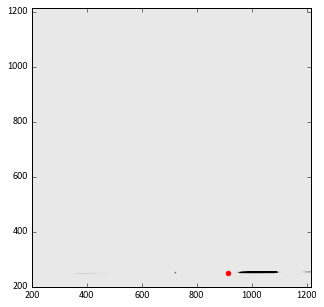

In [9]:
### Make sure these are initialized
flt.object_dispersers = collections.OrderedDict()
flt.model *= 0

### Compute model of a single object and catch the output, mag=-1 will force compute all orders
single_model = flt.compute_model_orders(id=id, compute_size=True, mag=-1, in_place=False)

### The other option is to store the model "in place" in the `flt.model` attribute.
status = flt.compute_model_orders(id=id, compute_size=True, mag=-1, in_place=True)
print 'These should be the same: %.3f %.3f' %(single_model.sum(), flt.model.sum())

## Show it
plt.imshow(single_model*10, interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')

plt.scatter(xseg, yseg, marker='o', color='r') # position in direct image

plt.xlim(flt.pad, flt.direct.sh[1]-flt.pad)
plt.ylim(flt.pad, flt.direct.sh[0]-flt.pad)

In [10]:
### Now compute the full FLT model
import collections
import time

## Only fit objects brighter than 26th mag (AB)
keep = flt.catalog['mag'] < 26

## Reset
flt.object_dispersers = collections.OrderedDict()
flt.model *= 0

## Helper function that loops over `self.compute_model_orders` for many objects
## Result is stored in the `self.model` attribute.
t0 = time.time()
flt.compute_full_model(ids=flt.catalog['id'][keep], 
                       mags=flt.catalog['mag'][keep])

t1 = time.time()
print 'Compute full model (%d objects): %.2f sec' %(keep.sum(), (t1-t0)*1)

Compute full model (179 objects): 0.90 sec


When `compute_model_orders` is run for a given object with `store=True` (default), the code caches helper objects for each beam (i.e., spectral order) of that object in the dictionary attribute `object_dispersers`.  Running `compute_model_orders` again will be faster by a significant factor as these don't have to be recalculated (though they do take up memory).

In [11]:
t0 = time.time()
flt.compute_full_model(ids=flt.catalog['id'][keep], 
                       mags=flt.catalog['mag'][keep])

t1 = time.time()
print 'Compute full model *again* (%d objects): %.2f sec' %(keep.sum(), (t1-t0)*1)

Compute full model *again* (179 objects): 0.14 sec


(200, 1214)

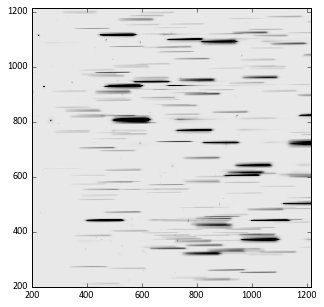

In [12]:
# Full model
plt.imshow(flt.model, interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')
plt.xlim(flt.pad, flt.direct.sh[1]-flt.pad)
plt.ylim(flt.pad, flt.direct.sh[0]-flt.pad)

(200, 1214)

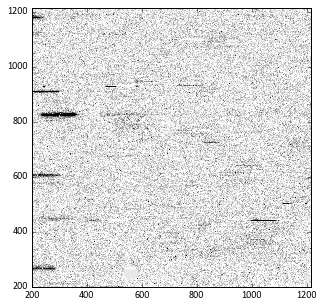

In [13]:
# residual
plt.imshow(flt.grism.data['SCI'] - flt.model, interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')
plt.xlim(flt.pad, flt.direct.sh[1]-flt.pad)
plt.ylim(flt.pad, flt.direct.sh[0]-flt.pad)
# Note, some spectra on the left side of the image aren't modeled because they fall off of 
# the direct image.  This can be accounted for when using reference mosaics that cover areas 
# larger than the FLT frames themselves.

# Also, this is just a crude model with simple (wrong) assumptions about the shapes of the object spectra!

#### Spectral orders
The dispersion objects for each beam of each id are stored in the `flt.object_dispersers` attribute.  We can show the observed and model spectra for each order with the following.

Spectral orders:  OrderedDict([('A', <grizlidev.model.GrismDisperser object at 0x11e3ae250>), ('B', <grizlidev.model.GrismDisperser object at 0x11e3ae910>)])
(32, 62)
(32, 213)


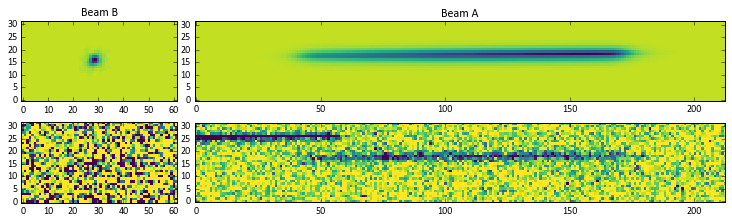

In [14]:
### Re-run again to make sure beams are stored, in case didn't run the full loop as above
if id not in flt.object_dispersers:
    flt.compute_model_orders(id=id, compute_size=True, mag=-1, store=True)

### Get the beams/orders
beams = flt.object_dispersers[id]
print 'Spectral orders: ', beams

### Make a figure showing the model (top) and observed (bottom) spectra
### for the first and zeroth orders.
fig = plt.figure(figsize=[10,3])
gs = matplotlib.gridspec.GridSpec(2, 2,
                       width_ratios=[1,3.4],
                       height_ratios=[1,1])

for i, b in enumerate(['B','A']):
    beam = beams[b]
    print beam.sh_beam
    
    model = beam.compute_model(id=id, spectrum_1d=beam.spectrum_1d, in_place=False)
    vmax = model.max()
    
    #ax = fig.add_subplot(221+i)
    ax = fig.add_subplot(gs[0,i])
    ax.imshow(model.reshape(beam.sh_beam), interpolation='Nearest', origin='lower', cmap='viridis_r', 
              vmin=-0.1*vmax, vmax=vmax)
    
    ax.set_title('Beam %s' %(b))
    
    ### Cutout of observed data
    sci_cutout = beam.cutout_from_full_image(flt.grism.data['SCI'])
    ax = fig.add_subplot(gs[1,i]) #fig.add_subplot(223+i)
    ax.imshow(sci_cutout, interpolation='Nearest', origin='lower', cmap='viridis_r', 
              vmin=-0.1*vmax, vmax=vmax)

fig.tight_layout(pad=0.1)

## The `BeamCutout` object
To interact more closely with an individual object, its information can be extracted from the full exposure with the `BeamCutout` class.  This object will contain the high-level `GrismDisperser` object useful for generating the model spectra and it will also have tools for analyzing and fitting the observed spectra.

It also makes detailed cutouts of the parent direct and grism images preserving the native WCS information.

Available computed beams/orders for id=6: ['A', 'B']

`beam` class: <class 'grizlidev.model.GrismDisperser'>

`co` class: <class 'grizlidev.model.BeamCutout'>

Object 6, total flux density within the segmentation region: 6.279e-19 erg/s/cm2/A


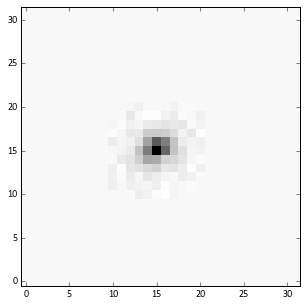

In [15]:
reload(grizli.model)
print 'Available computed beams/orders for id=%d: %s\n' %(id, flt.object_dispersers[id].keys())
beam = flt.object_dispersers[id]['A'] # can choose other orders if available
beam.compute_model()
print '`beam` class: %s\n' %(beam.__class__)

### BeamCutout object
co = grizli.model.BeamCutout(flt, beam, conf=flt.conf)
print '`co` class: %s\n' %(co.__class__)

print 'Object %d, ' %(co.id) + \
      'total flux density within the segmentation region: %.3e erg/s/cm2/A'%(co.beam.total_flux)
    
### Show the direct image
plt.imshow(co.beam.direct*(co.beam.seg == id), interpolation='Nearest', cmap='gray_r', origin='lower')

In [16]:
### Can write the BeamCutout object to a normal FITS file
co.write_fits(root='galaxy', clobber=True)

## The direct image extensions have EXTNAME=1 (e.g., ('SCI',1)) and
## the grism extensions have EXTNAME=2
im = pyfits.open('galaxy_%05d.A.fits' %(id))
print im[0].header.cards
print im.info()

## Can initialize a BeamCutout object from the FITS file 
## independent of the `flt` and `beam` objects as above.
co2 = grizli.model.BeamCutout(from_fits='galaxy_%05d.A.fits' %(id))

# test
print 'Flux is the same?: %.2e %.2e' %(co.beam.total_flux, co2.beam.total_flux)

('SIMPLE', True, 'conforms to FITS standard')
('BITPIX', 8, 'array data type')
('NAXIS', 0, 'number of array dimensions')
('EXTEND', True, '')
('ID', 6, 'Object ID')
('PAD', 200, 'Padding of input image')
('BEAM', 'A', 'Grism order ("beam")')
Filename: galaxy_00006.A.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       7   ()              
1    SCI         ImageHDU       201   (32, 32)     float64   
2    ERR         ImageHDU       201   (32, 32)     float32   
3    DQ          ImageHDU       201   (32, 32)     int16   
4    SEG         ImageHDU       201   (32, 32)     int32   
5    SCI         ImageHDU       178   (213, 32)    float64   
6    ERR         ImageHDU       178   (213, 32)    float32   
7    DQ          ImageHDU       178   (213, 32)    int16   
8    CONTAM      ImageHDU       178   (213, 32)    float64   
9    MODEL       ImageHDU       178   (213, 32)    float64   
None
Flux is the same?: 6.28e-19 6.28e-19


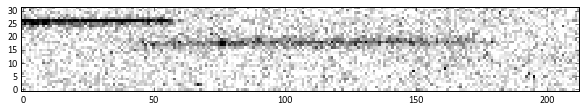

In [17]:
# Show the spectrum cutout
plt.imshow(co.grism.data['SCI'], interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')

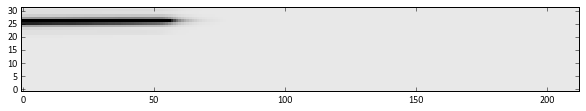

In [18]:
# Show the contamination model, which was cutout of `flt.model`
plt.imshow(co.contam, interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')

## `BeamCutout.beam.compute_model`

This is the high-level function for computing the 2D spectral model.  By default (with no user input) it assumes a flat $f_\lambda$ spectrum normalized to the total flux within the segmentation region.  

To compute a different arbitrary spectrum, provide a parameter `spectrum_1d = [wave, flux]`.

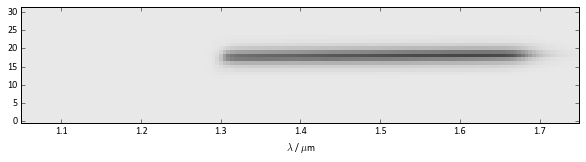

In [19]:
##### quick demo of a cartoon "break" spectrum showing how compute_model works
xspec = np.arange(1.e4, 2.e4,10.)
yspec = (xspec > 1.3e4)*1. # zero at xspec < 1.3e4
dummy_spectrum = co.beam.compute_model(spectrum_1d=[xspec, yspec], in_place=False)

## Plot it
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(dummy_spectrum.reshape(co.beam.sh_beam), interpolation='Nearest', vmin=-0.02, vmax=0.2, 
           cmap='gray_r', origin='lower')

## Helper functions for 2D plot axes
co.beam.twod_axis_labels(limits=[1.0, 1.81, 0.1], wscale=1.e4, mpl_axis=ax)
co.beam.twod_xlim(1.05, 1.75, wscale=1.e4, mpl_axis=ax)
ax.set_xlabel(r'$\lambda$ / $\mu$m')

In [20]:
# beam.compute_model is quite fast, if still rate-limiting for, e.g., 
# MCMC simulations with thousands of calls, though generating the 
# model spectra and evaluating the likelihood is probably slower.
%timeit co.beam.compute_model(in_place=True)

# Can be a bit slower for high resolution template specra since have 
# to do some interpolation along the way
xspec = np.arange(1.e4, 2.e4,10.)
yspec = (xspec > 1.4e4)*1. # zero at xspec < 1.4e4
%timeit beam.compute_model(in_place=True, spectrum_1d=[xspec, yspec])

xspec = np.arange(1.e4, 2.e4,0.1) # high-res spectrum, slower
yspec = (xspec > 1.4e4)*1. # zero at xspec < 1.4e4
%timeit beam.compute_model(in_place=True, spectrum_1d=[xspec, yspec])

10000 loops, best of 3: 160 µs per loop
10000 loops, best of 3: 216 µs per loop
1000 loops, best of 3: 474 µs per loop


### 1D "optimal" extractions
The `BeamCutout` class includes a method for computing a 1D optimal extraction of the object spectrum following [Horne (1986)](http://adsabs.harvard.edu/abs/1986PASP...98..609H), where "optimal" refers to the weighting that minimizes the variance in the resulting spectrum by scaling by the object profile along the spatial axis.  Of course collapsing to 1D **always** throws away the spatial information that is needed to interpret the morphology of the spectrum, and this information is often *scientifically* useful, for example in the case of extracting spatially-resolved 2D emission line maps.  Nevertheless, the 1D extractions are often useful for plotting, provided that the *modeling* is done on the full 2D spectrum and the model 1D spectrum is simply extracted in the same way as the data for plotting.

/Users/brammer/.local/lib/python2.7/site-packages/grizlidev/model.py:374: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


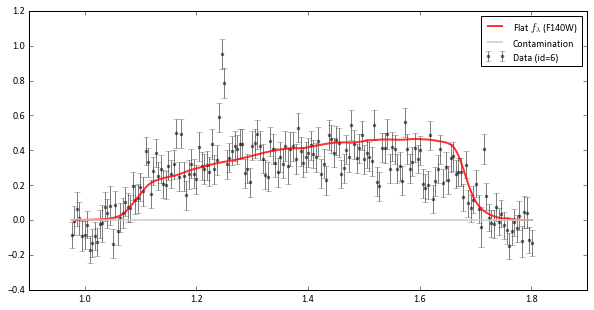

In [21]:
# flat continuum, by default `in_place=False` returns a flat array that needs to be reshaped
cmodel = co.beam.compute_model(in_place=False).reshape(co.beam.sh_beam)

# 1D optimal extraction (Horne 1986)
xspec, yspec, yerr = co.beam.optimal_extract(co.grism.data['SCI'], bin=0, ivar=co.ivar) #data
xspecm, yspecm, yerrm = co.beam.optimal_extract(cmodel, bin=0, ivar=co.ivar) # continuum model
xspecc, yspecc, yerrc = co.beam.optimal_extract(co.contam, bin=0, ivar=co.ivar) # contamination model

eb = plt.errorbar(xspec/1.e4, yspec, yerr, linestyle='None', marker='o', markersize=3, color='black', 
             alpha=0.5, label='Data (id=%d)' %(co.beam.id))

pl = plt.plot(xspecm/1.e4, yspecm, color='red', linewidth=2, alpha=0.8, 
         label=r'Flat $f_\lambda$ (%s)' %(co.direct.filter))

pl = plt.plot(xspecc/1.e4, yspecc, color='0.8', linewidth=2, alpha=0.8, 
         label=r'Contamination')

plt.legend(loc='upper right', fontsize=10)

## Fitting demo: continuum slope and a single emission line
The `BeamCutout.simple_line_fit` method demonstrates a fitting routine that fits for emission line strengths and the continuum shape, where the line centers are fit along a grid spanning the wavelength range of the G141 grism. 

The function first computes the simple flat continuum 2D model spectrum, $C_{i,j}$, as shown earlier.  Then at each line wavelength, $\lambda$, it computes an emission line only model spectrum where the line flux is normalized to unity, $L_{i,j}$.  Scale factors ($\alpha_C$, $\alpha_L$) are then computed with standard least squares techniques [(sklearn.linear_model)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to fit the sum of these models to the observed 2D spectrum $S_{i,j}$, which has known (2D) variance, $\sigma^2_{i,j}$ taken directly from the ERR extensions of the FLT images.

We include an additional term for modifying the *slope* of the continuum model, $\alpha_m$, so the final coefficient equation is

$\alpha_C C_{i,j} + \alpha_m \hat\lambda_j C_{i,j} + \alpha_L L_{i,j} = S_{i,j}$, 

where $\hat\lambda_j$ is the wavelength of pixel column $j$, suitably normalized so that $\alpha_m$ is of order unity.

For `BeamCutout.simple_line_fit`, the `fwhm` parameter specifies the width of the test emission line and `grid` is a list of parameters `[wave_min, wave_max, dwave, skip]`.  To get smooth $\chi^2$ functions, choose `fwhm` of order or larger than the grism pixel size (e.g., 46 Å for WFC3/G141).

Number of calls: 530, time=0.643 sec
min(chi_nu) = 1.15, nu~1260
z_Halpha ~ 0.896 (external z_spec = 0.895)


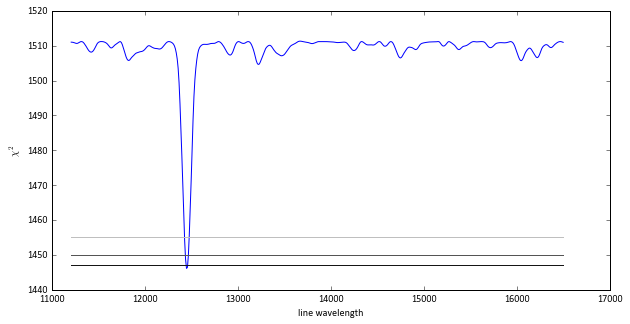

In [22]:
#### Demo fitting function.  
## Note that inverse variances are precomputed and stored in BeamCutout.ivar for chisq calculations
t0 = time.time()
out = co.simple_line_fit(fwhm=48, grid=[1.12e4, 1.65e4, 1, 10], poly_order=3)
line_centers, coeffs, chi2, ok_data, best_model, best_model_cont, best_line_center, best_line_flux = out
t1 = time.time()
print 'Number of calls: %d, time=%.3f sec' %(len(line_centers), t1-t0)

print 'min(chi_nu) = %.2f, nu~%d' %(chi2.min()/ok_data.sum(), ok_data.sum()) # non-masked pixels
# found a line!
print 'z_Halpha ~ %.3f (external z_spec = %.3f)' %(line_centers[np.argmin(chi2)]/6563.-1, 0.895)

# plot chisq as a function of line wavelength
plt.plot(line_centers, chi2); plt.xlabel('line wavelength'); plt.ylabel(r'$\chi^2$')
for dchi2 in [1,4,9]: plt.plot(line_centers, chi2*0+chi2.min()+dchi2, color='%s'%(dchi2/12.))

(32, 213) (32, 213)


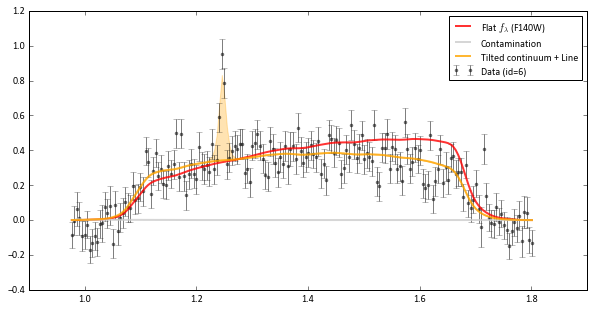

In [23]:
#### show best-fit models in 1D 
print best_model.shape, best_model_cont.shape

xspec_line, yspec_line, yerr_line = co.beam.optimal_extract(best_model, bin=0, ivar=co.ivar) # line model
xspec_cont, yspec_cont, yerr_cont = co.beam.optimal_extract(best_model_cont, bin=0, ivar=co.ivar) # continuum model

plt.errorbar(xspec/1.e4, yspec, yerr, linestyle='None', marker='o', markersize=3, color='black', 
             alpha=0.5, label='Data (id=%d)' %(co.beam.id))

plt.plot(xspecm/1.e4, yspecm, color='red', linewidth=2, alpha=0.8, 
         label=r'Flat $f_\lambda$ (%s)' %(co.direct.filter))

plt.plot(xspecc/1.e4, yspecc, color='0.8', linewidth=2, alpha=0.8, 
         label=r'Contamination')

plt.plot(xspec_cont/1.e4, yspec_cont, color='orange', linewidth=2, alpha=0.8, 
         label=r'Tilted continuum + Line')
plt.fill_between(xspec_cont/1.e4, yspec_line, yspec_cont, color='orange', alpha=0.3)

plt.legend(loc='upper right', fontsize=10)

/Users/brammer/anaconda2/lib/python2.7/site-packages/matplotlib/gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


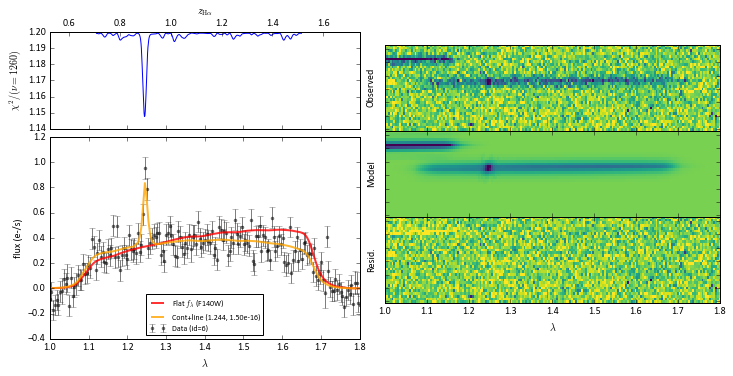

In [24]:
### Function for making a nice figure of the fit
fig = co.show_simple_fit_results(out)
fig.savefig('test.pdf', dpi=300)